In [38]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")

In [39]:
df = pd.read_csv('LSTM.csv', header = None)
print("Predicted Closing Values from LSTM Model")
df.head()

Predicted Closing Values from LSTM Model


,0
0,2243.911621
1,2248.770996
2,2253.678955
3,2260.759033
4,2270.071289


In [41]:
from collections import deque
import random

stock_name = "AMZN"

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 512, activation = tf.nn.relu)
        tensor_action, tensor_validation = tf.split(feed,2,1)
        feed_action = tf.layers.dense(tensor_action, self.action_size)
        feed_validation = tf.layers.dense(tensor_validation, 1)
        self.logits = feed_validation + tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost, starting_money))

In [42]:
close = df[0].values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 212.052002.3, cost: 0.223276, total money: 4938.146484
epoch: 20, total rewards: -156.235840.3, cost: 0.157116, total money: 9843.764160
epoch: 30, total rewards: -653.258789.3, cost: 0.098578, total money: 9346.741211
epoch: 40, total rewards: -764.542969.3, cost: 0.172223, total money: 9235.457031
epoch: 50, total rewards: -606.101318.3, cost: 0.144803, total money: 9393.898682
epoch: 60, total rewards: -543.240723.3, cost: 0.053011, total money: 9456.759277
epoch: 70, total rewards: -659.237061.3, cost: 0.048271, total money: 9340.762939
epoch: 80, total rewards: -457.385010.3, cost: 0.058900, total money: 9542.614990
epoch: 90, total rewards: -208.650879.3, cost: 0.048044, total money: 9791.349121
epoch: 100, total rewards: 62.960693.3, cost: 0.054759, total money: 10062.960693
epoch: 110, total rewards: -56.341309.3, cost: 0.039878, total money: 9943.658691
epoch: 120, total rewards: -361.472900.3, cost: 0.074220, total money: 9638.527100
epoch: 130, tota

In [44]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 6: buy 1 unit at price 2288.937256, total balance 7711.062744
day 7: buy 1 unit at price 2296.313477, total balance 5414.749268
day 8: buy 1 unit at price 2299.213867, total balance 3115.535400
day 10: buy 1 unit at price 2293.815186, total balance 821.720215
day 13, sell 1 unit at price 2290.980713, investment 0.089275 %, total balance 3112.700928,
day 15, sell 1 unit at price 2292.114502, investment -0.182857 %, total balance 5404.815430,
day 16, sell 1 unit at price 2286.838379, investment -0.538249 %, total balance 7691.653809,
day 17, sell 1 unit at price 2281.600830, investment -0.532491 %, total balance 9973.254639,
day 26: buy 1 unit at price 2330.151367, total balance 7643.103271
day 29: buy 1 unit at price 2324.520752, total balance 5318.582520
day 30: buy 1 unit at price 2320.208008, total balance 2998.374512
day 31: buy 1 unit at price 2317.263916, total balance 681.110596
day 32, sell 1 unit at price 2316.685059, investment -0.577916 %, total balance 2997.795654,
day 3

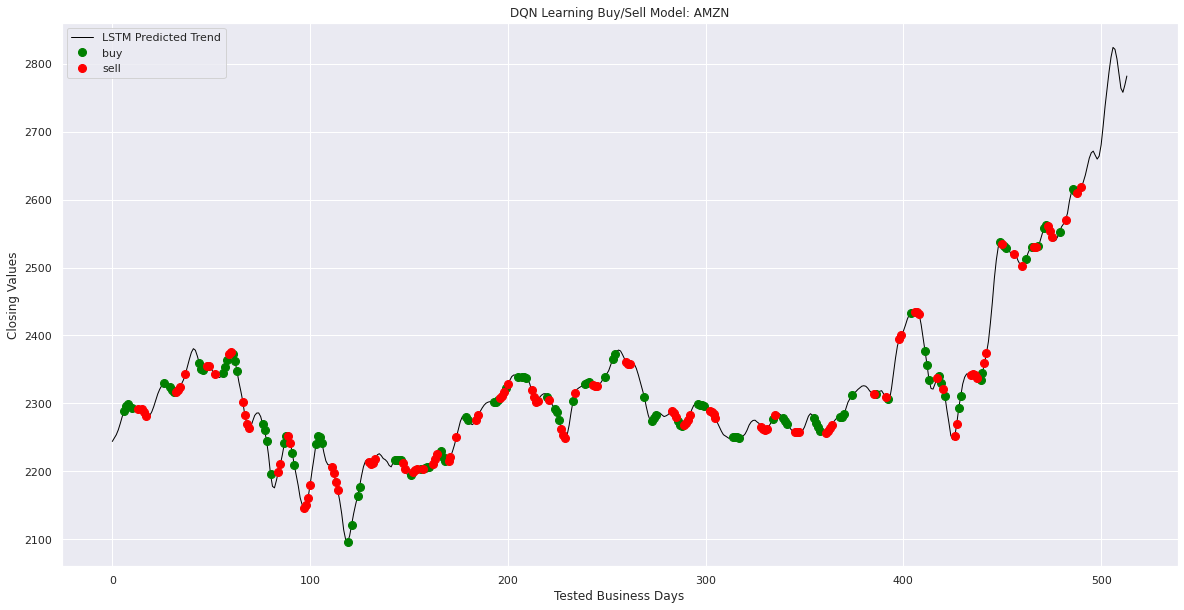

total gains -362.815674, total investment -3.628157%


In [45]:
fig = plt.figure(figsize = (20,10))
plt.plot(close, color='black', label = "LSTM Predicted Trend", linewidth=1)
plt.plot(close, 'o', markersize=8, color='green', label = 'buy', markevery = states_buy)
plt.plot(close, 'o', markersize=8, color='red', label = 'sell', markevery = states_sell)
plt.title("DQN Learning Buy/Sell Model: " + stock_name)
plt.ylabel("Closing Values")
plt.xlabel("Tested Business Days")
plt.legend(loc = "best")
plt.show()
print('total gains %f, total investment %f%%'%(total_gains, invest))